In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import itertools
import seaborn as sns
import os

# Parameters

In [2]:

latent_size = 64
hidden_size = 256
image_size = 784
batch_size = 50
device = 'cpu'

# Define noise types and parameters
noise_types = ['normal', 'uniform', 'lognormal', 'exponential', 'gamma', 'poisson', 'random_binary']
noise_params = {
    'normal': {'noise_std': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0], 'noise_mean': [0.0, 1.0, -1.0, 5.0, -5.0]},
    'uniform': {'noise_min': [-1.0, 0.0], 'noise_max': [0.5, 1.0]},
    'lognormal': {'noise_std': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0], 'noise_mean': [0.0, 1.0, -1.0, 5.0, -5.0]},
    'exponential': {'noise_lambda': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]},
    'gamma': {'noise_alpha': [1.0, 2.0, 3.0], 'noise_beta': [1.0, 2.0]},
    'poisson': {'noise_lambda': [1.0, 2.0, 5.0]},
    'random_binary': {}
}


# Load models

In [3]:

def load_models_by_id(run_id, model_dir='models'):
    # List all files in the model directory
    files = os.listdir(model_dir)
    
    # Find the correct discriminator and generator file based on the run_id
    discriminator_file = next((f for f in files if f.startswith(f"discriminator_{run_id}_") and f.endswith(".pth")), None)
    generator_file = next((f for f in files if f.startswith(f"generator_{run_id}_") and f.endswith(".pth")), None)

    if discriminator_file is None or generator_file is None:
        raise FileNotFoundError(f"Model files for run ID {run_id} not found.")
    
    # Construct full file paths
    discriminator_path = os.path.join(model_dir, discriminator_file)
    generator_path = os.path.join(model_dir, generator_file)
    
    # Load the discriminator and generator models
    discriminator = torch.load(discriminator_path, weights_only=True)
    generator = torch.load(generator_path, weights_only=True)

    return discriminator, generator

In [4]:

# Define Generator
class Generator(nn.Module):
    def __init__(self, input_size=latent_size, hidden_size=hidden_size, output_size=image_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.fc4 = nn.Linear(hidden_size, input_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        # x = self.relu(self.fc2(x))
        x = self.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))
        return x

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size=image_size, hidden_size=hidden_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.fc4 = nn.Linear(hidden_size, input_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        # x = self.relu(self.fc2(x))
        # x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x
    
# Load generator and discriminator
noise_dim = latent_size


# Instantiate the models with the known architecture
G = Generator()
D = Discriminator()


# Load the saved models from .pth files
run_id = 'xvtgqt97'  # Example run ID (without timestamp)
discriminator, generator = load_models_by_id(run_id)

# Load the state dict into the models
G.load_state_dict(generator)
D.load_state_dict(discriminator)

# Set the models to evaluation mode
G.eval()
D.eval()

Discriminator(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (fc4): Linear(in_features=256, out_features=784, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

# Define functions

In [5]:
# Function for generating noise as given
def generate_noise(batch_size, latent_size, noise_type='normal', config=None):
    if noise_type == 'normal':
        z = torch.randn(batch_size, latent_size).to(device) * config['noise_std'] + config['noise_mean']

    elif noise_type == 'uniform':
        z = torch.rand(batch_size, latent_size).to(device) * (config['noise_max'] - config['noise_min']) + config['noise_min']

    elif noise_type == 'exponential':
        z = torch.distributions.Exponential(config['noise_lambda']).sample((batch_size, latent_size)).to(device)

    elif noise_type == 'lognormal':
        z = torch.distributions.LogNormal(config['noise_mean'], config['noise_std']).sample((batch_size, latent_size)).to(device)

    elif noise_type == 'gamma':
        z = torch.distributions.Gamma(config['noise_alpha'], config['noise_beta']).sample((batch_size, latent_size)).to(device)

    elif noise_type == 'poisson':
        z = torch.poisson(torch.full((batch_size, latent_size), config['noise_lambda'])).to(device)

    elif noise_type == 'random_binary':
        z = torch.randint(0, 2, (batch_size, latent_size)).float().to(device)  # Binary random noise

    else:
        raise ValueError(f"Unsupported noise type: {noise_type}")

    return z

In [6]:
def plot_noise_raw(noise_type_, config_, z):
    # Prepare to plot
    fig, ax = plt.subplots(figsize=(15, 8))  # Single plot, no need for multiple axes

    # Plot the provided noise data
    ax.plot(z.cpu().numpy().flatten())  # Plotting the flattened noise

    # Create title string from noise type and config
    config_str = ", ".join(f"{k}={v}" for k, v in config_.items())
    ax.set_title(f"{noise_type_.capitalize()} Noise\n{config_str}")
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')

    # Show the plot
    plt.show()

In [7]:
def plot_noise_histogram(z, noise_type, config):
    z_numpy = z.cpu().numpy().flatten()

    # Plot distribution using Kernel Density Estimation (KDE)
    fig, ax = plt.subplots(figsize=(15, 8))  # Single plot, no need for multiple axes
    sns.kdeplot(z_numpy, fill=True)

    # Format the plot title and labels
    config_str = ", ".join(f"{k}={v}" for k, v in config.items())
    ax.set_title(f"{noise_type.capitalize()} Noise\n{config_str}", fontsize=20)
    ax.set_xlabel('Value', fontsize=18)
    ax.set_ylabel('Count', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=18)  # Tick labels font size



In [8]:
def visualize_noise_as_image(z, index=0):
    """
    Visualizes a single noise vector as a 28x28 grayscale image.

    Parameters:
        z (torch.Tensor): The noise vector to visualize, expected shape (batch_size, latent_size).
        index (int): The index of the noise vector in the batch to visualize.
    """
    # Extract the specific noise vector and reshape it to 28x28
    side = int(np.sqrt(len(z[0])))
    noise_image = z[index].reshape(side, side).cpu().detach().numpy()

    # Display the noise as an image
    plt.figure(figsize=(5, 5))
    plt.imshow(noise_image, cmap='gray')
    plt.title(f"Noise Vector as {side}x{side} Image (Index {index})")
    plt.axis('off')
    plt.show()

In [9]:
def visualize_fake_image(z, index=0):
    """
    Visualizes a single noise vector as a 28x28 grayscale image.

    Parameters:
        z (torch.Tensor): The noise vector to visualize, expected shape (batch_size, latent_size).
        index (int): The index of the noise vector in the batch to visualize.
    """
    global D, G

    # Extract the specific noise vector and reshape it to 28x28
    

    fake_images = G(z)
    outputs = D(fake_images)
    score = outputs.mean().item()

    side = int(np.sqrt(len(fake_images[0])))
    noise_image = fake_images[index].reshape(side, side).cpu().detach().numpy()

    # Display the noise as an image
    plt.figure(figsize=(5, 5))
    plt.imshow(noise_image, cmap='gray')
    plt.title(f"Fake image -> score:{score:.3f}")
    plt.axis('off')
    plt.show()

# Generate Noise

In [10]:
noise_params = {
    'normal': {'noise_std': 10.0, 'noise_mean': 1.0}, 
}

noise_type_ = 'normal'
config_ = noise_params[noise_type_]

z = generate_noise(2, latent_size, noise_type_, config_) 

z

tensor([[ -0.8072,   2.5588,   7.8392,  11.8708,   5.7191,  14.5591,  -0.2489,
          -0.3392, -20.3225,  13.9493, -17.1287,  -6.7058,   7.5105,   3.9372,
          11.1908,  16.8668,  -1.0995,   3.4784, -25.3006,  -1.5519,  -0.5983,
          -2.0065,   2.2549,   1.0078, -24.8507,  16.2055,  -8.3526,  -9.4927,
           3.2715,  -7.5045,  -3.2631, -10.4985,  -1.6997,   2.2001,  -4.2729,
          -0.6082,   2.0600,  -8.4364,   6.4428,   3.1023,  -3.4342, -10.3911,
         -16.7457,  13.0388,  16.7486, -16.8604,  -9.6871,  -1.7464,  -5.9602,
          -3.4538,  -4.4174,  -4.2729,   5.4188,  -1.5409,  -2.2113,   7.5058,
          -0.4590,  12.1283,   0.7307,   5.1590,  -2.7416,  19.9750,  12.7181,
           1.1072],
        [ -6.5713,   5.4090,  17.5006,  -8.5693,   5.3329,  -6.6933,   7.4639,
           2.7832,  -0.5883, -10.4394,  -2.2138,   3.1549,  -2.0893,  11.3257,
           8.5284,  -0.1500,  12.4886,  12.1402,  -0.7517,  15.9697,  -4.2718,
           1.5921, -15.8184,   5

# Visualize Noise - raw

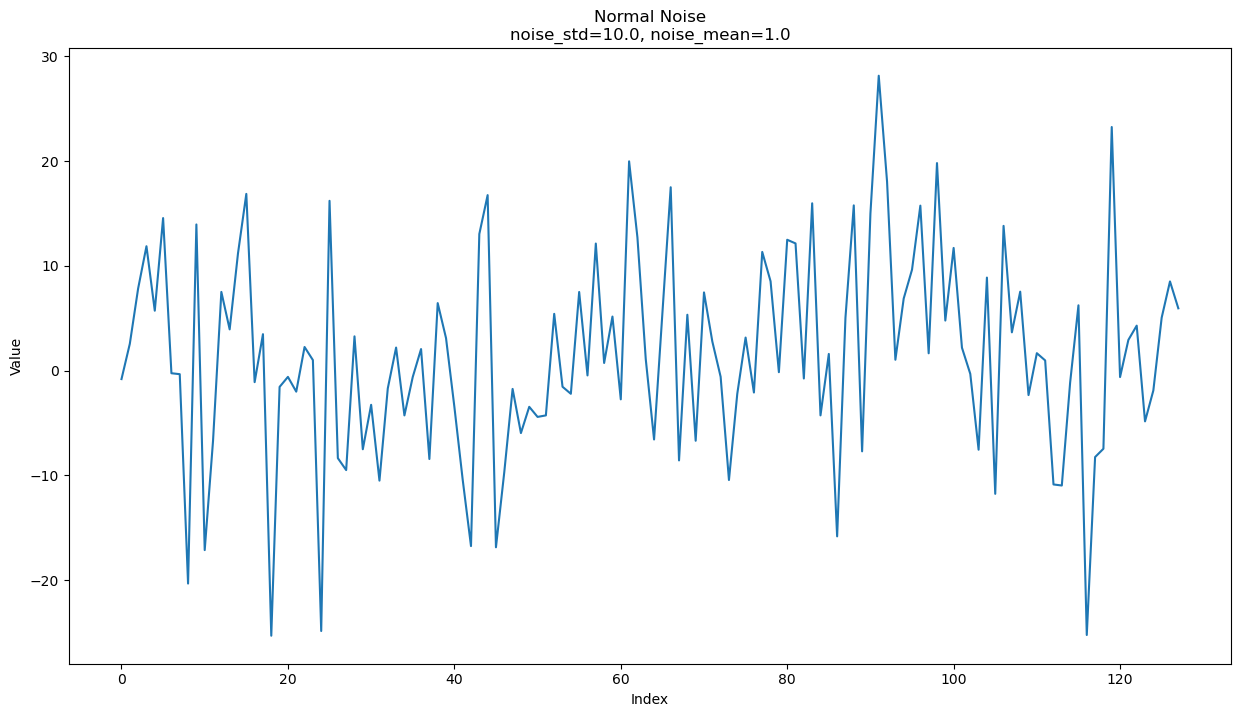

In [11]:
plot_noise_raw(noise_type_, config_, z)

# Visualize noise - distribution

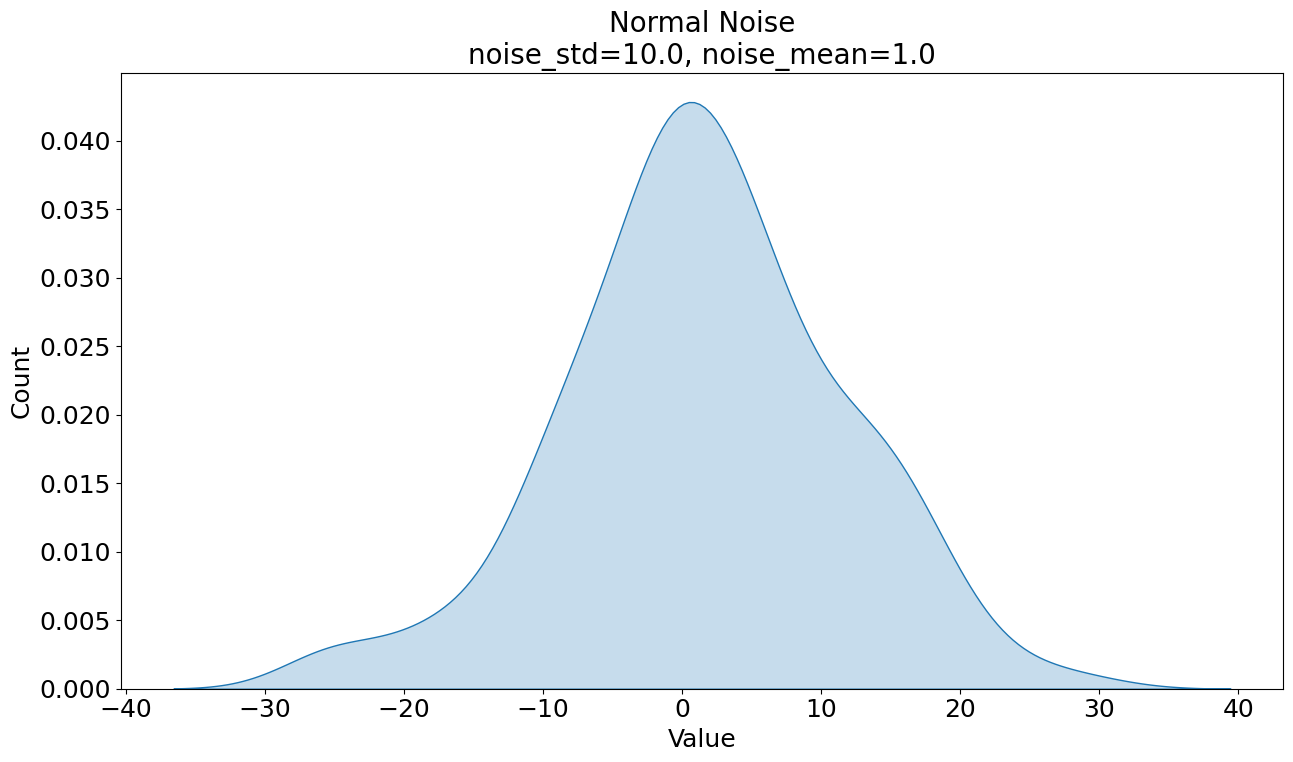

In [12]:
plot_noise_histogram(z, noise_type_, config_, )

# Visualize noise - image

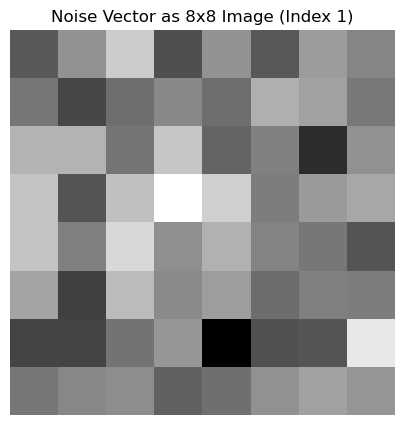

In [13]:
index_ = 1
visualize_noise_as_image(z, index=index_)


# Generate number from noise

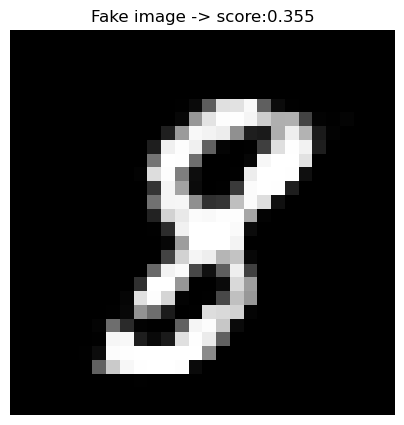

In [14]:
index_ = 1
visualize_fake_image(z, index=index_)

# Multiple runs

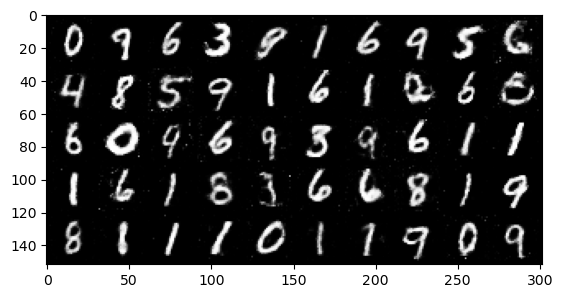

D(G(z)): 0.29


In [15]:
noise_params = {
    'normal': {'noise_std': 5.0, 'noise_mean': 0.0}, 
}

noise_type_ = 'normal'
config_ = noise_params[noise_type_]

z = generate_noise(batch_size, latent_size, noise_type_, config_) 

fake_images = G(z)
outputs = D(fake_images)
fake_score = outputs

with torch.no_grad():
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    grid = make_grid(fake_images, nrow=10, normalize=True)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()



print(f"D(G(z)): {fake_score.mean().item():.2f}")

In [20]:
import torch
import torchvision.transforms as transforms
from torchvision import models

# Load the trained classifier model
classifier = torch.load('mnist_classifier/mnist_cnn.pt')
# classifier.eval()  # Set the model to evaluation mode

# Define the image preprocessing steps (adjust as needed for your model)
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Example size, adjust if needed
    transforms.Grayscale(),       # Ensure images are in grayscale if needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] if needed
])

# Generate fake images
z = generate_noise(batch_size, latent_size, noise_type_, config_)  # Example function
fake_images = G(z)  # Pass noise through generator

# Convert fake images to the correct format and preprocess
fake_images = fake_images.cpu().detach()  # Ensure images are on CPU and detached from graph
# fake_images = torch.clamp(fake_images, 0, 1)  # Clamp to [0, 1] if needed

# Apply transformations if necessary
# fake_images = torch.stack([transform(img) for img in fake_images])

# Classify the images
with torch.no_grad():
    predictions = classifier(fake_images)

# Get the predicted classes
_, predicted_classes = torch.max(predictions, 1)

# Print the predicted classes
print(predicted_classes)


TypeError: 'collections.OrderedDict' object is not callable